# Research for TA and Testing


In [1]:
import pandas as pd
import ccxt
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import tensorflow as tf
import joblib


# Data Collection


,date,open,high,low,close,volume,datetime,MACD,Trend,200EMA,STOCHRSIk,STOCHRSId,BandWidth,BuySignal,SellSignal
33,1577882700000,7198.88,7198.88,7196.33,7196.33,0.038982,2020-01-01 12:45:00,0.896439,Above,7193.532892,59.823698,49.744268,0.197965,False,False
34,1577883000000,7200.17,7202.87,7200.17,7202.87,0.044424,2020-01-01 12:50:00,1.135273,Above,7195.230548,77.750181,63.148262,0.214636,True,False
35,1577883300000,7202.88,7205.30,7202.88,7205.30,0.147930,2020-01-01 12:55:00,1.352567,Above,7197.061358,86.424318,74.666066,0.190077,True,False
36,1577883600000,7207.54,7207.54,7201.37,7201.37,0.038656,2020-01-01 13:00:00,1.136007,Above,7197.844747,93.670144,85.948214,0.165534,True,False
37,1577883900000,7202.32,7202.32,7196.60,7196.83,0.126529,2020-01-01 13:05:00,0.617350,Above,7197.660248,70.828414,83.640959,0.192858,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1578171300000,7338.07,7338.07,7338.07,7338.07,0.001376,2020-01-04 20:55:00,1.313068,Above,7330.713713,85.372345,71.304887,0.284237,True,False
996,1578171600000,7333.64,7335.90,7333.29,7335.90,1.526298,2020-01-04 21:00:00,1.161472,Above,7331.656674,93.039864,84.145420,0.181791,True,False
997,1578171900000,7337.43,7337.43,7335.97,7336.71,0.688485,2020-01-04 21:05:00,1.022350,Above,7332.575461,88.874309,89.095506,0.148405,True,False
998,1578172200000,7339.01,7339.74,7339.01,7339.74,0.106567,2020-01-04 21:10:00,1.037683,Above,7333.878104,90.513989,90.809388,0.077946,True,False


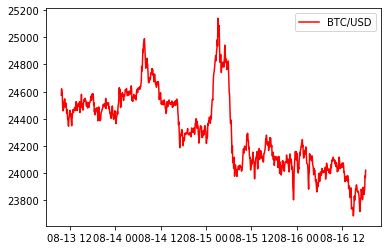

In [2]:
from datetime import datetime
from datetime import timedelta
exchange = ccxt.binanceus()


def get_data(start_date=None, timeframe='5m'):
    data = exchange.fetch_ohlcv(
        'BTC/USD', timeframe, limit=1000, since=start_date)
    df = pd.DataFrame(
        data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                         n_sign=9)['MACDh_12_26_9']
    df['macd_low'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                            n_sign=9)['MACD_12_26_9']
    df['macd_high'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                            n_sign=9)['MACDs_12_26_9']
    df['Trend'] = (df['macd_high'] <= 0) & (df['macd_low'] <= 0)
    df['Trend'] = df['Trend'].map({True: 'Below', False: 'Above'})
    df.drop(['macd_high', 'macd_low'], axis=1, inplace=True)
    df['200EMA'] = ta.ema(df['close'], n=200)
    df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
    df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
    df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
    df['BuySignal'] = ((df['close'] > df['200EMA']) & (df['MACD'] >= 1) & (
        df['STOCHRSId'] >= 50) & (df['STOCHRSId'] >= 50))
    df['SellSignal'] = ((df['MACD'] <= 0) & (df['STOCHRSId'] <= 50))
    df.dropna(inplace=True)
    return df


df = get_data()
plt.plot(df['datetime'], df['close'], color='red')
plt.legend(['BTC/USD'])
df.to_csv('data.csv')

# Fetch data since 1/1/2020


def convert_date(x): return datetime.strptime(x, '%Y-%m-%d')


n = convert_date('2020-01-01')
n = int(n.timestamp()) * 1000
df = get_data(start_date=n)

df


In [3]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
MACD


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
33,NaN,NaN,NaN
34,NaN,NaN,NaN
35,NaN,NaN,NaN
36,NaN,NaN,NaN
37,NaN,NaN,NaN
...,...,...,...
995,7.226325,5.681915,1.544410
996,9.197184,6.122219,3.074965
997,18.493245,12.334624,6.158621
998,24.590920,14.745839,9.845081


In [4]:
df = get_data()
ta.stochrsi(df['close'], n=14)


,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3
33,NaN,NaN
34,NaN,NaN
35,NaN,NaN
36,NaN,NaN
37,NaN,NaN
...,...,...
995,78.019225,82.527964
996,70.762192,76.254203
997,80.364476,76.381964
998,87.336314,79.487661


In [5]:
df = get_data()
bollinger = ta.bbands(df['close'], n=20, k=2)
bollinger


,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
33,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN
37,24502.327368,24576.870,24651.412632,0.606608,0.046904
...,...,...,...,...,...
995,23825.501044,23868.012,23910.522956,0.356217,0.497154
996,23828.616073,23865.174,23901.731927,0.306371,0.705920
997,23798.731724,23891.520,23984.308276,0.776747,0.969887
998,23796.846199,23907.028,24017.209801,0.921752,0.769881


Text(0.5, 1.0, 'STOCHRSI')

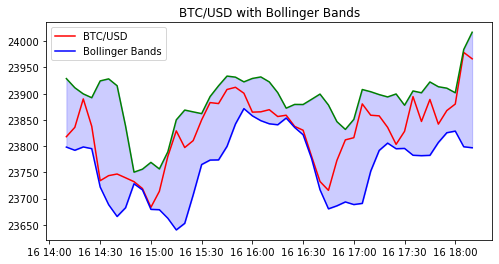

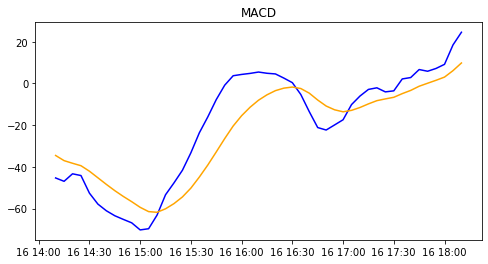

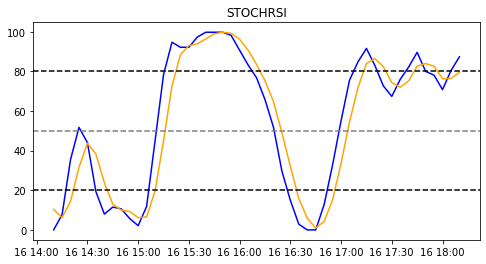

In [6]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
stochrsi = ta.stochrsi(df['close'], n=14)
bollinger = ta.bbands(df['close'], n=20, k=2)

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1], df['close'].iloc[-50:-1], color='red')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBL_5_2.0'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBU_5_2.0'].iloc[-50:-1], color='green')
plt.fill_between(df['datetime'].iloc[-50:-1], bollinger['BBL_5_2.0'].iloc[-50:-1],
                 bollinger['BBU_5_2.0'].iloc[-50:-1], color='blue', alpha=0.2)
plt.legend(['BTC/USD', 'Bollinger Bands'])
plt.title('BTC/USD with Bollinger Bands')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1],
         MACD['MACD_12_26_9'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         MACD['MACDs_12_26_9'].iloc[-50:-1], color='orange')
plt.title('MACD')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSIk_14_14_3_3'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSId_14_14_3_3'].iloc[-50:-1], color='orange')
plt.axhline(y=50, color='gray', linestyle='--')
plt.axhline(y=80, color='black', linestyle='--')
plt.axhline(y=20, color='black', linestyle='--')
plt.title('STOCHRSI')


# Ordering Algorithms

The strategy that will be implemented will be MACD focused with the confirmation from the STOCHRSI.  
<br>
If the difference of the MACD is positive, the strategy will be to buy the stock if the STOCHRSI is above the 50% level, indicating a strong trend. This will trigger an OCO order.
<br>
The stop loss will be set to -0.2% of the current price. and the Take-Profit will be 0.5% of the current price
<br>


# ML Integration

- Predict how much higher percentage the stock will be in 30 minutes.
  - Uses a Random Forest Classifier to predict the percentage increases.
  - Uses MACD, STOCHRSI, Volume, Bollinger Bands, and Close Price as features for linear regression to predict the next 30 minutes.


In [7]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
# shift(-6) is 30 minutes in the future
df['Next-Close'] = df['close'].shift(-6)
df.dropna(inplace=True)

df


,date,open,high,low,close,volume,datetime,MACD,Trend,200EMA,STOCHRSIk,STOCHRSId,BandWidth,BuySignal,SellSignal,Next-Close
66,1660393800000,24375.36,24415.30,24343.88,24347.84,7.577549,2022-08-13 12:30:00,3.115645,Below,24406.219055,54.281509,67.237216,0.528152,False,False,24448.60
67,1660394100000,24353.12,24392.19,24315.77,24388.00,18.649123,2022-08-13 12:35:00,3.383937,Below,24402.906500,54.131870,59.704275,0.505123,False,False,24471.31
68,1660394400000,24389.23,24430.12,24388.01,24424.81,8.538076,2022-08-13 12:40:00,6.108997,Below,24406.888954,67.416809,58.610063,0.433478,True,False,24462.23
69,1660394700000,24423.54,24453.71,24422.57,24436.40,2.881823,2022-08-13 12:45:00,8.607654,Below,24412.254599,87.819726,69.789468,0.523654,True,False,24468.43
70,1660395000000,24442.83,24485.56,24441.09,24466.29,16.057922,2022-08-13 12:50:00,11.981667,Below,24422.079217,97.962412,84.399649,0.671468,True,False,24479.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1660670700000,23835.72,23837.97,23782.51,23803.32,24.636771,2022-08-16 17:25:00,3.371357,Below,23826.036044,72.639749,82.369894,0.438125,False,False,23867.77
990,1660671000000,23809.74,23837.56,23785.00,23828.17,10.829522,2022-08-16 17:30:00,3.094306,Below,23826.424036,67.351165,74.306620,0.345580,True,False,23880.23
991,1660671300000,23826.12,23899.99,23815.34,23894.42,32.374754,2022-08-16 17:35:00,7.046727,Above,23838.786938,75.963209,71.984708,0.514498,True,False,23978.72
992,1660671600000,23890.29,23890.49,23831.85,23846.99,23.194166,2022-08-16 17:40:00,6.172053,Above,23840.278404,82.224815,75.179730,0.503276,True,False,23966.50


In [8]:
# df = get_data()
# df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
#                      n_sign=9)['MACDh_12_26_9']
# df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
# df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
# df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

# df


# # shift(-6) is 30 minutes in the future
# df['Next-Close'] = df['close'].shift(-6)
# df.dropna(inplace=True)
# features = df[['open', 'high', 'low', 'MACD', 'close','STOCHRSIk', 'STOCHRSId',
#                'BandWidth', 'volume']]
# labels = df['Next-Close']

# data = pd.concat([features, labels], axis=1)
# train_data = data.sample(frac=0.8, random_state=0)
# test_data = data.drop(train_data.index)
# train_features = train_data.drop('Next-Close', axis=1)
# train_labels = train_data['Next-Close']
# test_features = test_data.drop('Next-Close', axis=1)
# test_labels = test_data['Next-Close']
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=[len(train_features.columns)])
# ])
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(train_features, train_labels, epochs=500,
#             validation_split=0.2, verbose=1)
# predictions = model.predict(test_features)

# model.save('btc_model.h5')
# # model = tf.keras.models.load_model('myModel.h5')


In [9]:
from sklearn.metrics import mean_squared_error
# import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# print(model.evaluate(test_features, test_labels))
# print('RMSE: ', np.sqrt(mean_squared_error(test_labels, predictions)))
# print('MAE: ', mean_absolute_error(test_labels, predictions))
# print('R2: ', r2_score(test_labels, predictions))


# Training and Testing

- Making four seperate algorithms for 5,10,20,30 minutes in the future
- Returns a dataframe with percentage increase and the time it was predicted.


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def convert_date(x): return int(
    datetime.strptime(x, '%Y-%m-%d').timestamp()*1000)


def convert_date_with_time(x): return int(
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()*1000)


df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

df['FIVE_CLOSE'] = df['close'].shift(-1)
df['TEN_CLOSE'] = df['close'].shift(-2)
df['TWENTY_CLOSE'] = df['close'].shift(-4)
SHIFT = -6
# shift(-6) is 30 minutes in the future
df['THIRTY_CLOSE'] = df['close'].shift(SHIFT)
df.dropna(inplace=True)
SPLIT_RATIO = 0.6

features = np.array(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
labels = np.array(((df['THIRTY_CLOSE']-df['close'])/df['close'])*100)

five_Labels = np.array(((df['FIVE_CLOSE']-df['close'])/df['close'])*100)
ten_Labels = np.array(((df['TEN_CLOSE']-df['close'])/df['close'])*100)
twenty_Labels = np.array(((df['TWENTY_CLOSE']-df['close'])/df['close'])*100)
thirty_Labels = np.array(((df['THIRTY_CLOSE']-df['close'])/df['close'])*100)

train_features = features[:int(SPLIT_RATIO*len(features))]
test_features = features[int(SPLIT_RATIO*len(features)):]

train_labels = labels[:int(SPLIT_RATIO*len(features))]
test_labels = labels[int(SPLIT_RATIO*len(features)):]
# Create different models for each label
five_train_labels = five_Labels[:int(SPLIT_RATIO*len(features))]
five_test_labels = five_Labels[int(SPLIT_RATIO*len(features)):]
ten_train_labels = ten_Labels[:int(SPLIT_RATIO*len(features))]
ten_test_labels = ten_Labels[int(SPLIT_RATIO*len(features)):]
twenty_train_labels = twenty_Labels[:int(SPLIT_RATIO*len(features))]
twenty_test_labels = twenty_Labels[int(SPLIT_RATIO*len(features)):]
thirty_train_labels = thirty_Labels[:int(SPLIT_RATIO*len(features))]
thirty_test_labels = thirty_Labels[int(SPLIT_RATIO*len(features)):]


# Create a model for each label
five_model = RandomForestRegressor(n_estimators=100, random_state=0)
ten_model = RandomForestRegressor(n_estimators=100, random_state=0)
twenty_model = RandomForestRegressor(n_estimators=100, random_state=0)
thirty_model = RandomForestRegressor(n_estimators=100, random_state=0)


# Train the models
five_model.fit(train_features, five_train_labels)
ten_model.fit(train_features, ten_train_labels)
twenty_model.fit(train_features, twenty_train_labels)
thirty_model.fit(train_features, thirty_train_labels)


# Test the models
five_predictions = five_model.predict(test_features)
ten_predictions = ten_model.predict(test_features)
twenty_predictions = twenty_model.predict(test_features)
thirty_predictions = thirty_model.predict(test_features)


In [11]:
joblib.dump(five_model, "./five_model.joblib", compress=3)
joblib.dump(ten_model, "./ten_model.joblib", compress=3)
joblib.dump(twenty_model, "./twenty_model.joblib", compress=3)
joblib.dump(thirty_model, "./thirty_model.joblib", compress=3)


['./thirty_model.joblib']

In [12]:
def get_accuracy(test_labels, predictions, name=None):
    print(f'{name} MSE: {mean_squared_error(test_labels, predictions)}')
    print(f'{name} MAE: {mean_absolute_error(test_labels, predictions)}')
    print(f'{name} R2: {r2_score(test_labels, predictions)}')
    print(f'{name} RMSE: {np.sqrt(mean_squared_error(test_labels, predictions))}')


names = ['Five', 'Ten', 'Twenty', 'Thirty']
predictions = [five_predictions, ten_predictions,
               twenty_predictions, thirty_predictions]

for i in range(len(predictions)):
    get_accuracy(test_labels, predictions[i], names[i])


Five MSE: 0.12264066732990397
Five MAE: 0.26409455282188643
Five R2: -0.045575545001314666
Five RMSE: 0.35020089567261814
Ten MSE: 0.1304483187350312
Ten MAE: 0.27348581733935956
Ten R2: -0.11213983848429421
Ten RMSE: 0.36117629868947826
Twenty MSE: 0.14965390558437516
Twenty MAE: 0.287864070457009
Twenty R2: -0.27587746625710463
Twenty RMSE: 0.38685127062525615
Thirty MSE: 0.16499277039283486
Thirty MAE: 0.3054074473513237
Thirty R2: -0.40664927532321626
Thirty RMSE: 0.4061930211030648


In [13]:
# Test loading the model
five_model = ten_model = twenty_model = thirty_model = None


In [14]:
from datetime import datetime


def predict_next_close(df):
    df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                         n_sign=9)['MACDh_12_26_9']
    df['macd_low'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                             n_sign=9)['MACD_12_26_9']
    df['macd_high'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                              n_sign=9)['MACDs_12_26_9']
    df['Trend'] = (df['macd_high'] <= 0) & (df['macd_low'] <= 0)
    df['Trend'] = df['Trend'].map({True: 'Below', False: 'Above'})
    df.drop(['macd_high', 'macd_low'], axis=1, inplace=True)
    df['200EMA'] = ta.ema(df['close'], n=200)
    df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
    df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
    df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
    df['BuySignal'] = ((df['close'] > df['200EMA']) & (df['MACD'] > 0) & (df['STOCHRSId'] >= 50) & (df['STOCHRSId'] >= 50))
    df['BuySignal'] = df['BuySignal'].map({True:'Buy',False:'Hold'})
    df.dropna(inplace=True)
    # df['FIVE_CLOSE'] = df['close'].shift(-1)
    # df['TEN_CLOSE'] = df['close'].shift(-2)
    # df['TWENTY_CLOSE'] = df['close'].shift(-4)
    # df['THIRTY_CLOSE'] = df['close'].shift(-6)

    five_model = joblib.load("./models/five_model.joblib")
    ten_model = joblib.load("./models/ten_model.joblib")
    twenty_model = joblib.load("./models/twenty_model.joblib")
    thirty_model = joblib.load("./models/thirty_model.joblib")

    five_predictions = five_model.predict(
        df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    ten_predictions = ten_model.predict(
        df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    twenty_predictions = twenty_model.predict(
        df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    thirty_predictions = thirty_model.predict(
        df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    df['5 Minutes'] = five_predictions
    df['10 Minutes'] = ten_predictions
    df['20 Minutes'] = twenty_predictions
    df['30 Minutes'] = thirty_predictions
    df['Average'] = (df['5 Minutes'] + df['10 Minutes'] +
                     df['20 Minutes'] + df['30 Minutes'])/4
    return df


def convert_date(x): return datetime.strptime(x, '%Y-%m-%d')


n = convert_date('2020-01-01')
n = int(n.timestamp()) * 1000
df = get_data()
predictions = predict_next_close(df)
df.to_csv('predictions.csv')


In [15]:
df = get_data()
predict_next_close(df)
profit = (df['Average'].iloc[-1] * (df['close'].iloc[-1]/100)) + \
    df['close'].iloc[-1]
stop_loss = min([df['5 Minutes'].iloc[-1], df['10 Minutes'].iloc[-1],
                df['20 Minutes'].iloc[-1], df['30 Minutes'].iloc[-1]])
stop_loss = stop_loss * (df['close'].iloc[-1]/100) + df['close'].iloc[-1]
print('Price: ', df['close'].iloc[-1])
print('Profit: ', profit)
print('Stop Loss: ', stop_loss)


Price:  24037.93
Profit:  24046.163087557354
Stop Loss:  24030.83997896982


In [16]:
# model_loss = model.evaluate(test_features, test_labels)
# print(model_loss)


# New Model to indicate momentum


In [17]:
df = get_data()
# Create a regression to calculate a percentage change in price


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

# Percent change in price
df = get_data()
df['Change'] = (df['close'].shift(-6) - df['close']) / df['close'] * 100
df.dropna(inplace = True)



# Create a regression to calculate a percentage change in price
x_train, x_test, y_train, y_test = train_test_split(
    df[['volume', 'MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']], df['Change'], test_size=0.2)

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('Random Forest')
print('MSE: ', rf_mse)
print('MAE: ', rf_mae)
print('R2: ', rf_r2)

df['Prediction'] = rf.predict(df[['volume', 'MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])

df.to_csv('predictions.csv')


Random Forest
MSE:  0.1636001700960044
MAE:  0.2921521303347981
R2:  -0.021250945862649306


In [18]:
# Make a model that calculates stop-loss and take-profit
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['macd_low'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                         n_sign=9)['MACD_12_26_9']
df['macd_high'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                          n_sign=9)['MACDs_12_26_9']
df['Trend'] = (df['macd_high'] <= 0) & (df['macd_low'] <= 0)
df['Trend'] = df['Trend'].map({True: 'Below', False: 'Above'})
df.drop(['macd_high', 'macd_low'], axis=1, inplace=True)
df['200EMA'] = ta.ema(df['close'], n=200)
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
df['BuySignal'] = ((df['close'] > df['200EMA']) & (df['MACD'] > 0) & (
    df['STOCHRSId'] >= 50) & (df['STOCHRSId'] >= 50))
df.dropna(inplace=True)




